In [0]:
import numpy as np
import pandas as pd

In [3]:
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [0]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', engine='python')


In [5]:
from sklearn.impute import SimpleImputer

miss= SimpleImputer(strategy='constant', fill_value='') 
miss.fit(data)

SimpleImputer(add_indicator=False, copy=True, fill_value='', missing_values=nan,
              strategy='constant', verbose=0)

In [6]:
idata =miss.transform(data)
idata

array([[0, 767, 33, ..., 'Initmates', 'Intimate', 'Intimates'],
       [1, 1080, 34, ..., 'General', 'Dresses', 'Dresses'],
       [2, 1077, 60, ..., 'General', 'Dresses', 'Dresses'],
       ...,
       [23483, 1104, 31, ..., 'General Petite', 'Dresses', 'Dresses'],
       [23484, 1084, 28, ..., 'General', 'Dresses', 'Dresses'],
       [23485, 1104, 52, ..., 'General Petite', 'Dresses', 'Dresses']],
      dtype=object)

In [7]:
train=pd.DataFrame(data=idata,    # values
              index=data.index,    # 1st column as index
            columns=data.columns)  # 1st row as the column names
train.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [8]:
train.drop(['Clothing ID','Age'], axis =1, inplace=True)
train.drop(train.loc[:,'Division Name':'Class Name'], axis=1, inplace=True)
train.head()

,Unnamed: 0,Title,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,,Absolutely wonderful - silky and sexy and comfortable,4,1,0
1,1,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4
2,2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0
3,3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0
4,4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6


In [9]:
gc.collect()#Forces an immediate garbage collection of all generations to release unreferenced memory

183

In [23]:
df_train=train.copy()
df_train.shape
df_train.head()

,Unnamed: 0,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,All
0,0,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Absolutely wonderful - silky and sexy and comfortable
1,1,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite."
2,2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,"Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
3,3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,"My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!


In [24]:
df_train['All'] = df_train[['Title','Review Text' ]].apply(lambda x: ' '.join(x), axis=1)
df_train.head(7)

,Unnamed: 0,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,All
0,0,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Absolutely wonderful - silky and sexy and comfortable
1,1,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite."
2,2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,"Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c"
3,3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,"My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!"
4,4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!
5,5,Not for the very petite,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",2,0,4,"Not for the very petite I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress."
6,6,Cagrcoal shimmer fun,"I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bum

In [0]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [0]:
 def clean_review(review_col):
     review_corpus=[]
     for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
     return review_corpus

In [18]:

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
df_train['All']=clean_review(df_train['All'].values)
df_train.head()

,Unnamed: 0,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,All,Rating_Class
0,0,,Absolutely wonderful - silky and sexy and comfortable,4,1,0,absolutely wonderful silky and sexy and comfortable,1
1,1,,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,love this dress it s sooo pretty i happened to find it in a store and i m glad i did bc i never would have ordered it online bc it s petite i bought a petite and am i love the length on me hit just a little below the knee would definitely be a true midi on someone who is truly petite,1
2,2,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,some major design flaw i had such high hope for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which wa just ok overall the top half wa comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layer imo a major design flaw wa the net over layer sewn directly into the zipper it c,0
3,3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,my favorite buy i love love love this jumpsuit it s fun flirty and fabulous every time i wear it i get nothing but great compliment,1
4,4,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,flattering shirt this shirt is very flattering to all due to the adjustable front tie it is the perfect length to wear with legging and it is sleeveless so it pair well with any cardigan love this shirt,1


In [29]:
df_train['Rating_Class']=np.where(df_train['Rating']>3,1,0)
train_text=df_train.All.values
target=df_train.Rating_Class.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(23486,) (23486,) (23486, 2)


In [30]:
print(np.unique(y))
y.shape

[0. 1.]


(23486, 2)

In [31]:
#train test split
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(18788,) (18788, 2)
(4698,) (4698, 2)


In [32]:
#Finding number of unique words in train set
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

11614

In [0]:
AAll_words=' '.join(train_text)
all_words=word_tokenize(AAll_words)

numb_unique_word=len(dist)

In [50]:
numb_unique_word


11614

In [33]:
#Finding max length of a review in train set
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

123

In [0]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN#max length of a review in train set
batch_size = 128
epochs = 3
num_classes=2

In [0]:
#Tokenize Text

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)


In [37]:
#sequence padding

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
print(X_train.shape,X_val.shape)

(18788, 123) (4698, 123)


In [0]:
##############################################Glove word embedding- PRE TRAINED
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))#splitting on space
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)#max feature is num of unique words
    print('after stacking')

    embedding_matrix = np.random.normal(0, 1, 
                                        (num_words, embed_dim))# embedding dimension is 100d - the one we selected
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)# get value from embeddings_index when key is passed
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [39]:
# embedding matrix
EMBEDDING_FILE = 'glove.6B.100d.txt'
embed_dim = 100             #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 246321 word vectors.
after stacking
(11614, 100)


In [40]:
model5 = Sequential()
model5.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))#embedding_matrix ->pretrained glove
model5.add(SpatialDropout1D(0.25))
model5.add(Bidirectional(LSTM(128,return_sequences=True)))
model5.add(Bidirectional(LSTM(64,return_sequences=False)))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 123, 256)          234496    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258 

In [41]:
%%time
history5=model5.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=4, batch_size=batch_size, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 18788 samples, validate on 4698 samples
Epoch 1/4
18788/18788 [==============================] - 112s 6ms/step - loss: 0.4851 - acc: 0.7835 - val_loss: 0.3885 - val_acc: 0.8242
Epoch 2/4
18788/18788 [==============================] - 108s 6ms/step - loss: 0.3478 - acc: 0.8526 - val_loss: 0.2836 - val_acc: 0.8840
Epoch 3/4
18788/18788 [==============================] - 107s 6ms/step - loss: 0.2875 - acc: 0.8791 - val_loss: 0.3105 - val_acc: 0.8799
Epoch 4/4
18788/18788 [==============================] - 110s 6ms/step - loss: 0.2567 - acc: 0.8956 - val_loss: 0.2615 - val_acc: 0.9000
CPU times: user 10min 47s, sys: 1min 8s, total: 11min 56s
Wall time: 7min 18s


In [42]:
history5=model5.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=40, batch_size=batch_size, verbose=1)

Train on 18788 samples, validate on 4698 samples
Epoch 1/40
18788/18788 [==============================] - 110s 6ms/step - loss: 0.2232 - acc: 0.9086 - val_loss: 0.2375 - val_acc: 0.9063
Epoch 2/40
18788/18788 [==============================] - 108s 6ms/step - loss: 0.2092 - acc: 0.9180 - val_loss: 0.2246 - val_acc: 0.9057
Epoch 3/40
18788/18788 [==============================] - 108s 6ms/step - loss: 0.1903 - acc: 0.9272 - val_loss: 0.2343 - val_acc: 0.9076
Epoch 4/40
18788/18788 [==============================] - 107s 6ms/step - loss: 0.1747 - acc: 0.9318 - val_loss: 0.2347 - val_acc: 0.9115
Epoch 5/40
18788/18788 [==============================] - 107s 6ms/step - loss: 0.1636 - acc: 0.9393 - val_loss: 0.2453 - val_acc: 0.9066
Epoch 6/40
18788/18788 [==============================] - 106s 6ms/step - loss: 0.1482 - acc: 0.9435 - val_loss: 0.2469 - val_acc: 0.9072
Epoch 7/40
 8448/18788 [============>.................] - ETA: 52s - loss: 0.1322 - acc: 0.9524

KeyboardInterrupt: ignored

In [43]:
model6 = Sequential()
model6.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model6.add(SpatialDropout1D(0.25))
model6.add(Bidirectional(GRU(128,return_sequences=True)))
model6.add(Bidirectional(GRU(64,return_sequences=False)))
model6.add(Dropout(0.5))
model6.add(Dense(num_classes, activation='softmax'))
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 123, 256)          175872    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               123264    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,460,794
Trainable params: 1,460,794
Non-trainable params: 0
____________________________________________

In [44]:
history5=model6.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1)

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 90s 5ms/step - loss: 0.5135 - acc: 0.7726 - val_loss: 0.4152 - val_acc: 0.8195
Epoch 2/10
18788/18788 [==============================] - 86s 5ms/step - loss: 0.3282 - acc: 0.8557 - val_loss: 0.2591 - val_acc: 0.8891
Epoch 3/10
18788/18788 [==============================] - 86s 5ms/step - loss: 0.2545 - acc: 0.8968 - val_loss: 0.2258 - val_acc: 0.9085
Epoch 4/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.2336 - acc: 0.9051 - val_loss: 0.2380 - val_acc: 0.8995
Epoch 5/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.2032 - acc: 0.9207 - val_loss: 0.2232 - val_acc: 0.9138
Epoch 6/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.1903 - acc: 0.9269 - val_loss: 0.2252 - val_acc: 0.9104
Epoch 7/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.1755 - acc: 0.9327 - val_loss: 0.2218 - val_acc:

In [45]:
history5=model5.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1)

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 106s 6ms/step - loss: 0.1341 - acc: 0.9508 - val_loss: 0.2623 - val_acc: 0.9063
Epoch 2/10
18788/18788 [==============================] - 107s 6ms/step - loss: 0.1213 - acc: 0.9561 - val_loss: 0.2780 - val_acc: 0.9061
Epoch 3/10
18788/18788 [==============================] - 107s 6ms/step - loss: 0.1126 - acc: 0.9598 - val_loss: 0.2950 - val_acc: 0.9044
Epoch 4/10
18788/18788 [==============================] - 107s 6ms/step - loss: 0.1029 - acc: 0.9619 - val_loss: 0.2955 - val_acc: 0.9046
Epoch 5/10
18788/18788 [==============================] - 107s 6ms/step - loss: 0.0980 - acc: 0.9640 - val_loss: 0.2805 - val_acc: 0.8957
Epoch 6/10
18788/18788 [==============================] - 108s 6ms/step - loss: 0.0877 - acc: 0.9678 - val_loss: 0.3317 - val_acc: 0.9010
Epoch 7/10
18788/18788 [==============================] - 107s 6ms/step - loss: 0.0821 - acc: 0.9696 - val_loss: 0.3510 - v

KeyboardInterrupt: ignored

Spatial Dropout- This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.

In [51]:

model7 = Sequential()
model7.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model7.add(SpatialDropout1D(0.35))
model7.add(Bidirectional(GRU(128,return_sequences=True)))
model7.add(Bidirectional(GRU(64,return_sequences=False)))
model7.add(Dropout(0.5))
model7.add(Dense(num_classes, activation='softmax'))
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 123, 256)          175872    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               123264    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 1,460,794
Trainable params: 1,460,794
Non-trainable params: 0
____________________________________________

In [52]:
history5=model7.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1)

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 90s 5ms/step - loss: 0.5142 - acc: 0.7731 - val_loss: 0.3420 - val_acc: 0.8438
Epoch 2/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.3408 - acc: 0.8512 - val_loss: 0.2641 - val_acc: 0.8908
Epoch 3/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.2718 - acc: 0.8862 - val_loss: 0.2354 - val_acc: 0.9049
Epoch 4/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.2339 - acc: 0.9045 - val_loss: 0.2228 - val_acc: 0.9091
Epoch 5/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.2214 - acc: 0.9106 - val_loss: 0.2240 - val_acc: 0.9093
Epoch 6/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.1996 - acc: 0.9202 - val_loss: 0.2268 - val_acc: 0.9070
Epoch 7/10
 8192/18788 [============>.................] - ETA: 45s - loss: 0.1827 - acc: 0.9288

KeyboardInterrupt: ignored

In [63]:
model8 = Sequential()
model8.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model8.add(SpatialDropout1D(0.35))
model8.add(Bidirectional(GRU(128,return_sequences=True)))
model8.add(Bidirectional(GRU(64,return_sequences=False)))
model8.add(Dropout(0.5))
model8.add(Dense(num_classes, activation='softmax'))
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# simple early stopping


model8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 123, 256)          175872    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               123264    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 1,460,794
Trainable params: 1,460,794
Non-trainable params: 0
____________________________________________

In [64]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history5=model8.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1, callbacks=[es, mc])

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 94s 5ms/step - loss: 0.5127 - acc: 0.7698 - val_loss: 0.3486 - val_acc: 0.8453
Epoch 2/10
18788/18788 [==============================] - 90s 5ms/step - loss: 0.3380 - acc: 0.8542 - val_loss: 0.2561 - val_acc: 0.8900
Epoch 3/10
18788/18788 [==============================] - 89s 5ms/step - loss: 0.2655 - acc: 0.8915 - val_loss: 0.2479 - val_acc: 0.9004
Epoch 4/10
18788/18788 [==============================] - 90s 5ms/step - loss: 0.2365 - acc: 0.9034 - val_loss: 0.2360 - val_acc: 0.9066
Epoch 5/10
18788/18788 [==============================] - 90s 5ms/step - loss: 0.2204 - acc: 0.9129 - val_loss: 0.2239 - val_acc: 0.9095
Epoch 6/10
18788/18788 [==============================] - 91s 5ms/step - loss: 0.2042 - acc: 0.9216 - val_loss: 0.2349 - val_acc: 0.9087
Epoch 00006: early stopping


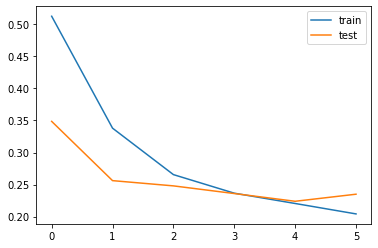

In [67]:
from matplotlib import pyplot
pyplot.plot(history5.history['loss'], label='train')
pyplot.plot(history5.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# training was stopped at the point when validation loss began to plateau for the first time.

In [68]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history8=model8.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1, callbacks=[es, mc])

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 89s 5ms/step - loss: 0.1925 - acc: 0.9242 - val_loss: 0.2221 - val_acc: 0.9110
Epoch 2/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.1832 - acc: 0.9293 - val_loss: 0.2251 - val_acc: 0.9115
Epoch 3/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.1704 - acc: 0.9352 - val_loss: 0.2349 - val_acc: 0.9138
Epoch 00003: early stopping


In [69]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history8=model8.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1, callbacks=[es, mc])

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 89s 5ms/step - loss: 0.1630 - acc: 0.9362 - val_loss: 0.2346 - val_acc: 0.9108
Epoch 2/10
18788/18788 [==============================] - 87s 5ms/step - loss: 0.1498 - acc: 0.9436 - val_loss: 0.2346 - val_acc: 0.9097
Epoch 3/10
18788/18788 [==============================] - 86s 5ms/step - loss: 0.1425 - acc: 0.9476 - val_loss: 0.2466 - val_acc: 0.9070
Epoch 4/10
18788/18788 [==============================] - 85s 5ms/step - loss: 0.1303 - acc: 0.9513 - val_loss: 0.2550 - val_acc: 0.9087
Epoch 00004: early stopping


Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

In [70]:
model9 = Sequential()
model9.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model9.add(SpatialDropout1D(0.35))
model9.add(Bidirectional(GRU(128,return_sequences=True)))
model9.add(Bidirectional(GRU(128,return_sequences=True)))
model9.add(Bidirectional(GRU(64,return_sequences=False)))
model9.add(Dropout(0.5))
model9.add(Dense(num_classes, activation='softmax'))
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 123, 256)          175872    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 123, 256)          295680    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               123264    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [71]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history9=model9.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1, callbacks=[es, mc])

Train on 18788 samples, validate on 4698 samples
Epoch 1/10
18788/18788 [==============================] - 136s 7ms/step - loss: 0.5334 - acc: 0.7646 - val_loss: 0.4115 - val_acc: 0.8135
Epoch 2/10
18788/18788 [==============================] - 127s 7ms/step - loss: 0.3546 - acc: 0.8450 - val_loss: 0.2553 - val_acc: 0.8963
Epoch 3/10
18788/18788 [==============================] - 126s 7ms/step - loss: 0.2761 - acc: 0.8832 - val_loss: 0.2374 - val_acc: 0.9042
Epoch 4/10
18788/18788 [==============================] - 125s 7ms/step - loss: 0.2397 - acc: 0.9038 - val_loss: 0.2269 - val_acc: 0.9055
Epoch 5/10
18788/18788 [==============================] - 125s 7ms/step - loss: 0.2186 - acc: 0.9126 - val_loss: 0.2246 - val_acc: 0.9093
Epoch 6/10
18788/18788 [==============================] - 125s 7ms/step - loss: 0.2075 - acc: 0.9178 - val_loss: 0.2244 - val_acc: 0.9100
Epoch 7/10
18788/18788 [==============================] - 125s 7ms/step - loss: 0.1884 - acc: 0.9251 - val_loss: 0.2274 - v

In [72]:
model10 = Sequential()
model10.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model10.add(SpatialDropout1D(0.25))
model10.add(Bidirectional(GRU(64,return_sequences=True)))
model10.add(Bidirectional(GRU(32,return_sequences=False)))
model10.add(Dropout(0.5))
model10.add(Dense(num_classes, activation='softmax'))
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 123, 100)          1161400   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 123, 100)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 123, 128)          63360     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                30912     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 1,255,802
Trainable params: 1,255,802
Non-trainable params: 0
____________________________________________

In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history10=model10.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=20, batch_size=batch_size, verbose=1, callbacks=[es, mc])

Train on 18788 samples, validate on 4698 samples
Epoch 1/20
18788/18788 [==============================] - 96s 5ms/step - loss: 0.5224 - acc: 0.7699 - val_loss: 0.3926 - val_acc: 0.8203
Epoch 2/20
18788/18788 [==============================] - 88s 5ms/step - loss: 0.3418 - acc: 0.8500 - val_loss: 0.2547 - val_acc: 0.8938
Epoch 3/20
18788/18788 [==============================] - 87s 5ms/step - loss: 0.2666 - acc: 0.8901 - val_loss: 0.2326 - val_acc: 0.9029
Epoch 4/20
18788/18788 [==============================] - 86s 5ms/step - loss: 0.2317 - acc: 0.9069 - val_loss: 0.2236 - val_acc: 0.9076
Epoch 5/20
18788/18788 [==============================] - 85s 5ms/step - loss: 0.2123 - acc: 0.9143 - val_loss: 0.2263 - val_acc: 0.9093
Epoch 6/20
18788/18788 [==============================] - 85s 5ms/step - loss: 0.1942 - acc: 0.9256 - val_loss: 0.2237 - val_acc: 0.9117
Epoch 00006: early stopping


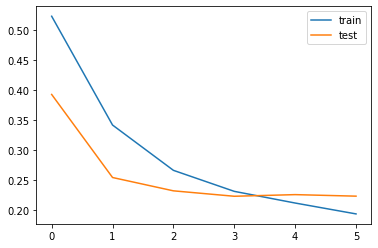

In [74]:
pyplot.plot(history10.history['loss'], label='train')
pyplot.plot(history10.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()